In [6]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression, Ridge, Lasso
# 데이터 로드
path = 'housingdata.csv'  
df = pd.read_csv(path)

from scipy.stats import shapiro, probplot

# 수치형 변수에 해당하는 열
n_columns = df.select_dtypes(include=['float64', 'int64']).columns
print(n_columns)


Index(['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX',
       'PTRATIO', 'B', 'LSTAT', 'MEDV'],
      dtype='object')


In [7]:
def shapiro_func(data, columns):
    normality_results = {}
    for col in columns:
        stat, p = shapiro(data[col].dropna())
        normality_results[col] = {
            "Stat": stat,
            "P": p,
            "Normal Distribution": p > 0.05  # P > 0.05: 정규 분포 가정
        }
        
 # 시각화: 히스토그램과 QQ 플롯
        plt.figure(figsize=(12, 5))
        #새로운 플롯 창을 생성합니다.
        #figsize는 창의 크기를 인치 단위로 설정
        plt.subplot(1, 2, 1)
        #1행 2열 첫번째 위치에 서브플롯 추가
        sns.histplot(data[col].dropna(), kde=True, bins=30)
        #data[col]은 시각화하려는 특정 열(column)의 데이터를 선택합니다.
        #히스토그램 위에 KDE(커널 밀도 추정) 곡선을 추가합니다.
        #히스토그램의 구간을 30개로 나눕니다.
        plt.title(f'Histogram of {col}')

        plt.subplot(1, 2, 2)
        probplot(data[col].dropna(), dist="norm", plot=plt)
        # 데이터를 주어진 분포(dist)와 비교하기 위한 점들을 생성합니다.
        # 'norm'은 정규분포를 의미, plot=plt :결과를 Matplotlib을 사용하여 그립니다
        plt.title(f'QQ Plot of {col}')
        plt.tight_layout()
        # 서브플롯 간의 간격을 자동으로 조정
        plt.show()        

    return pd.DataFrame(normality_results).T

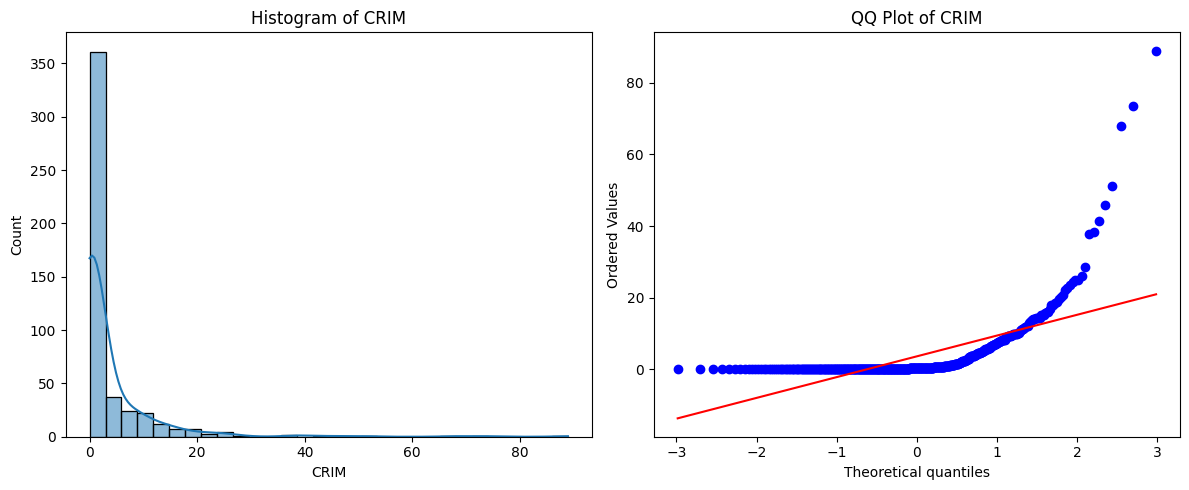

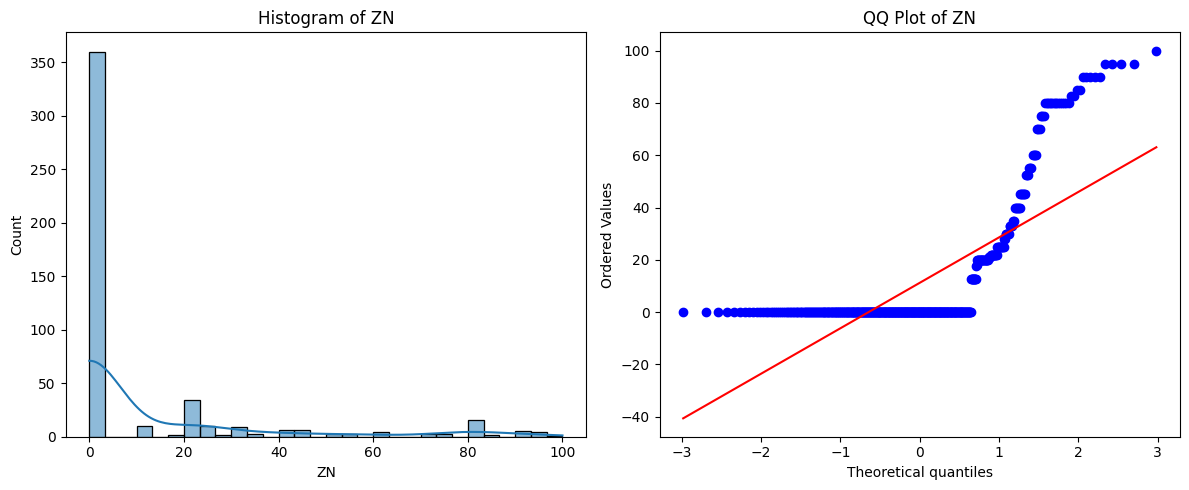

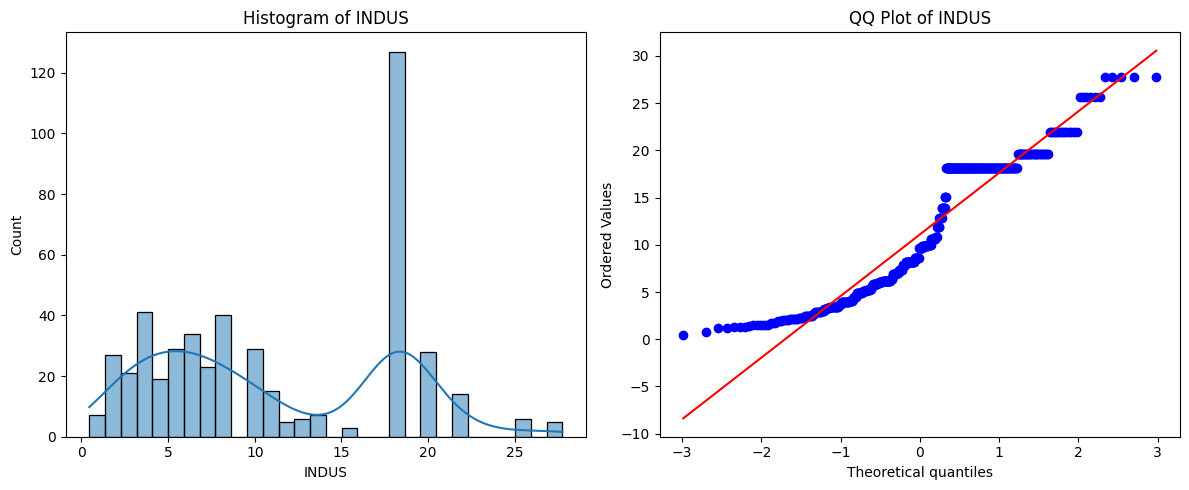

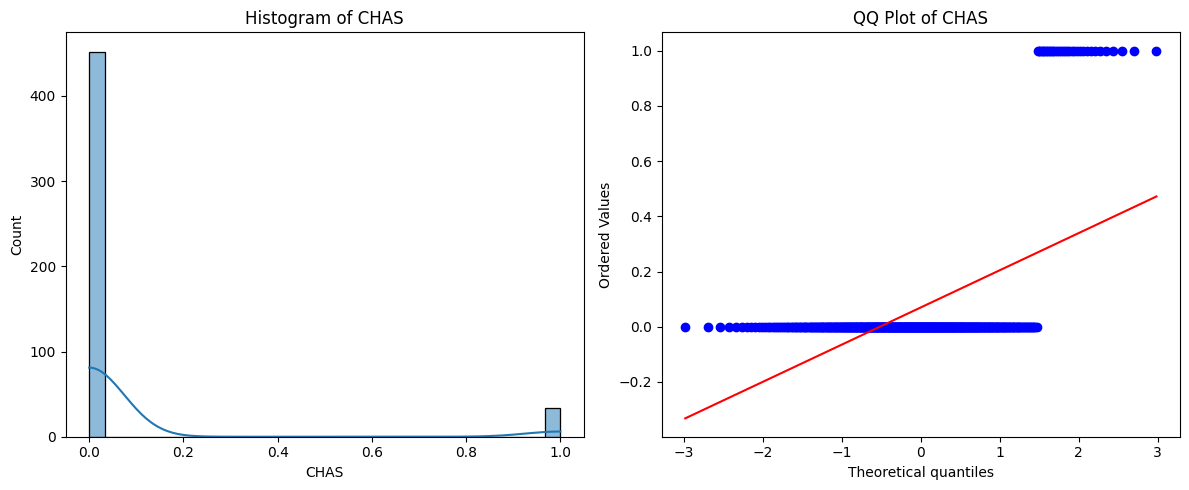

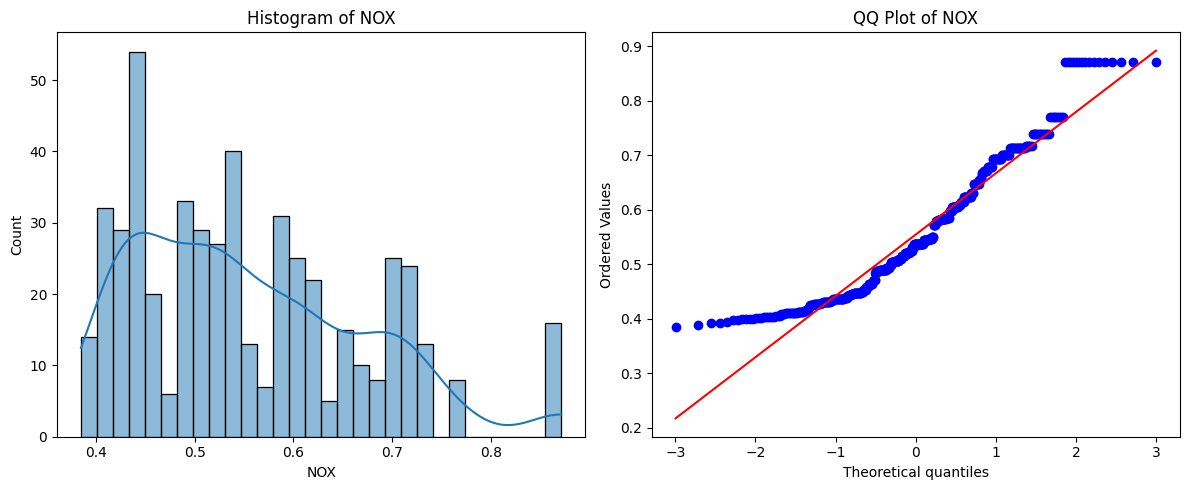

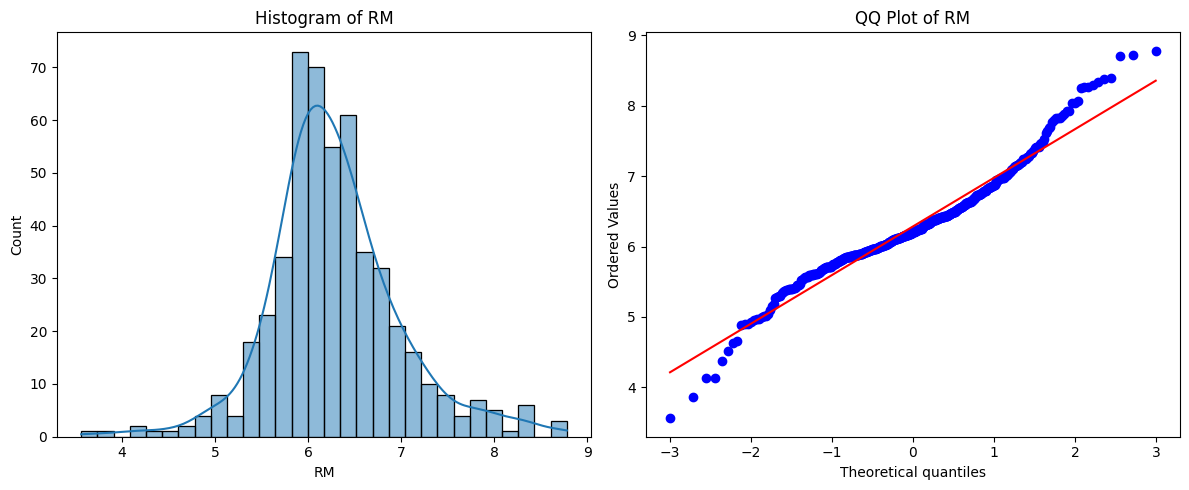

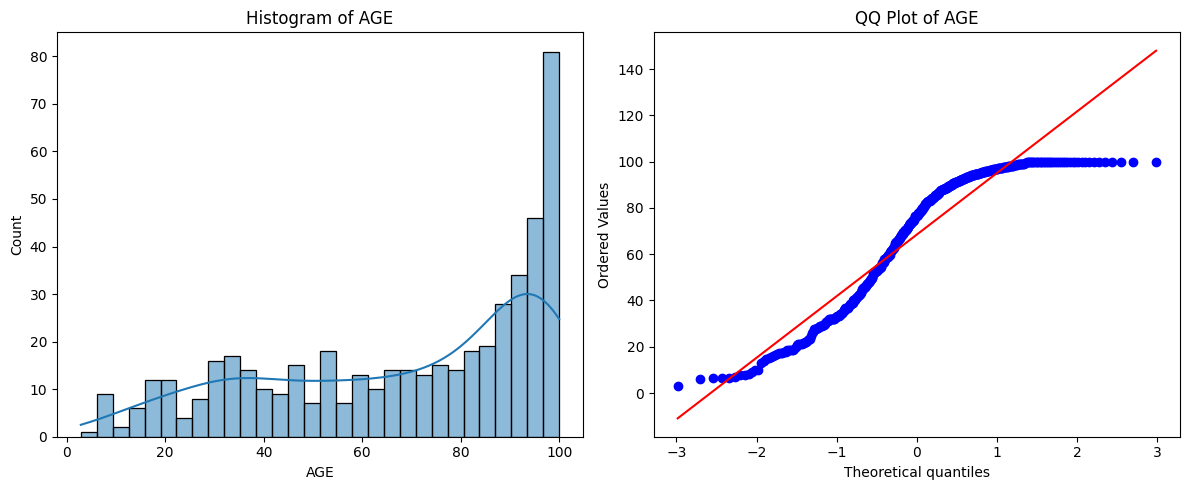

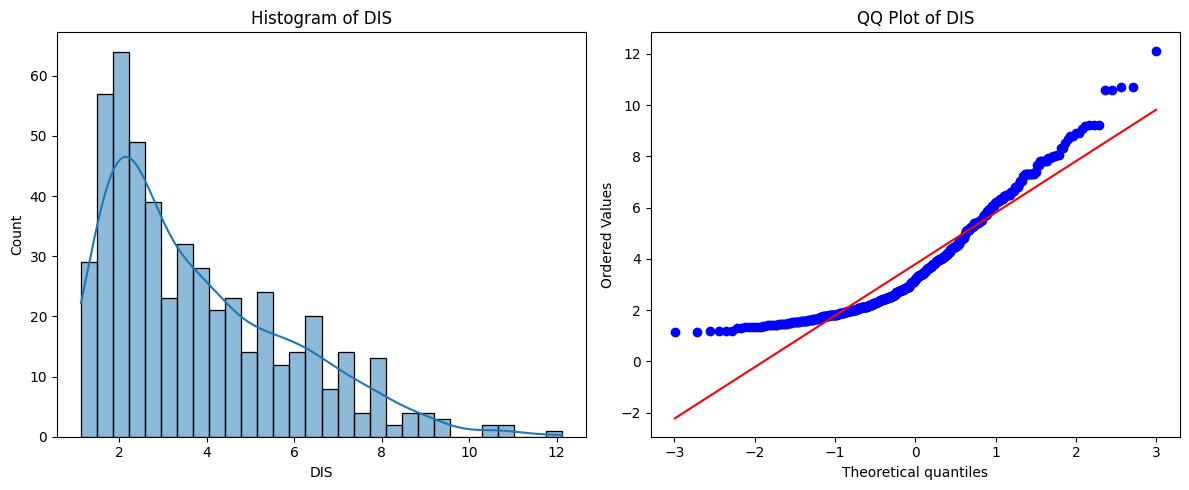

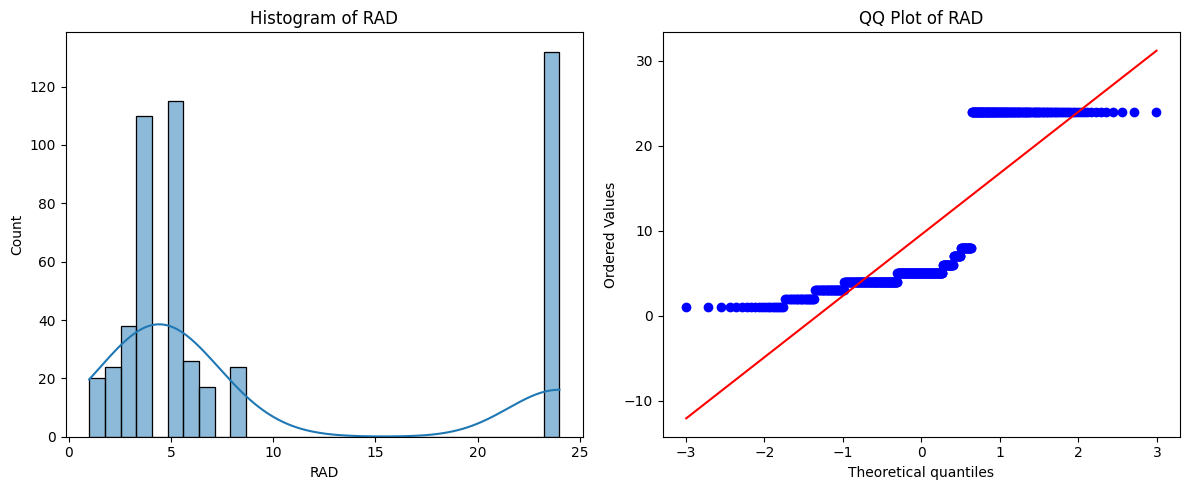

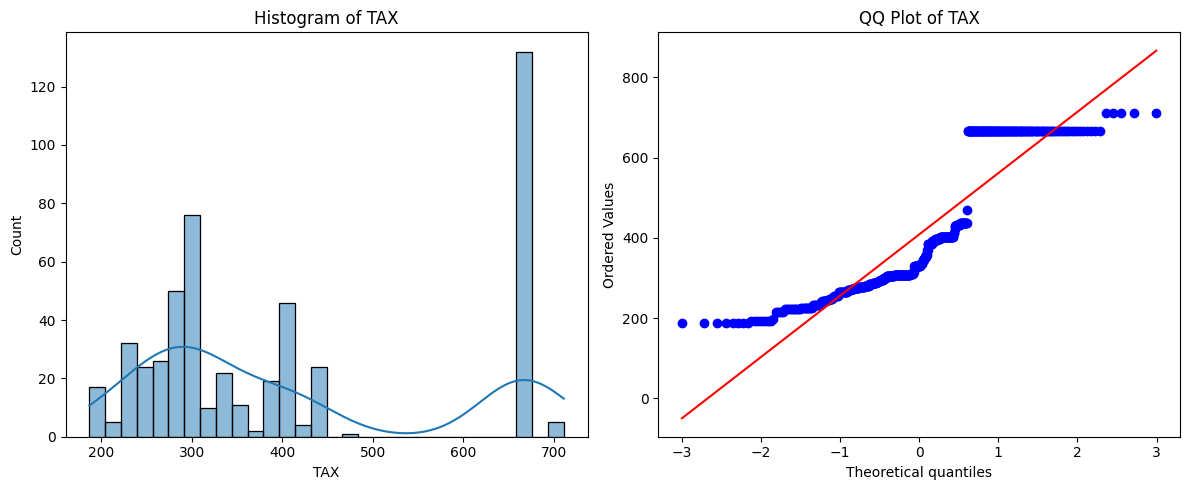

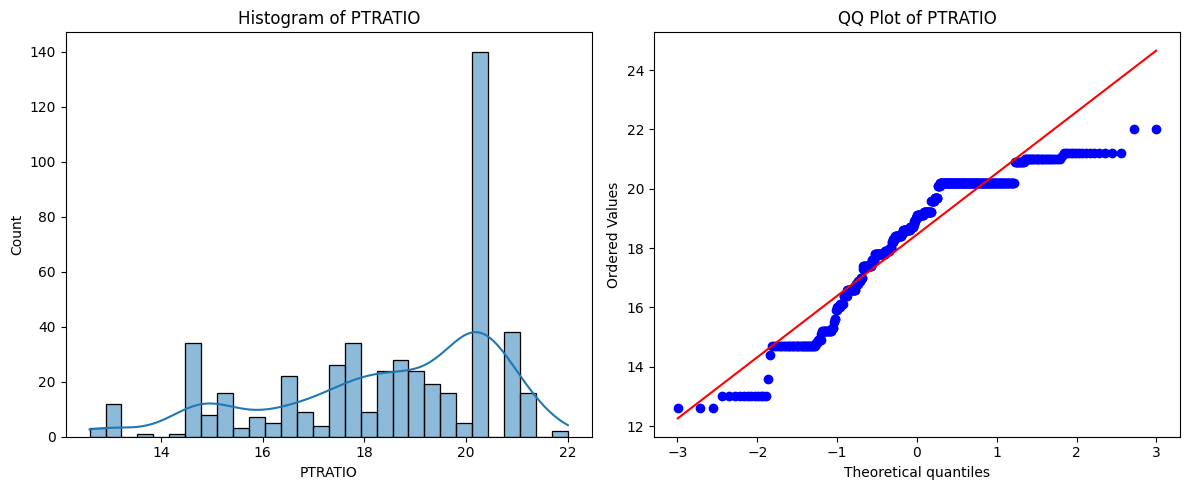

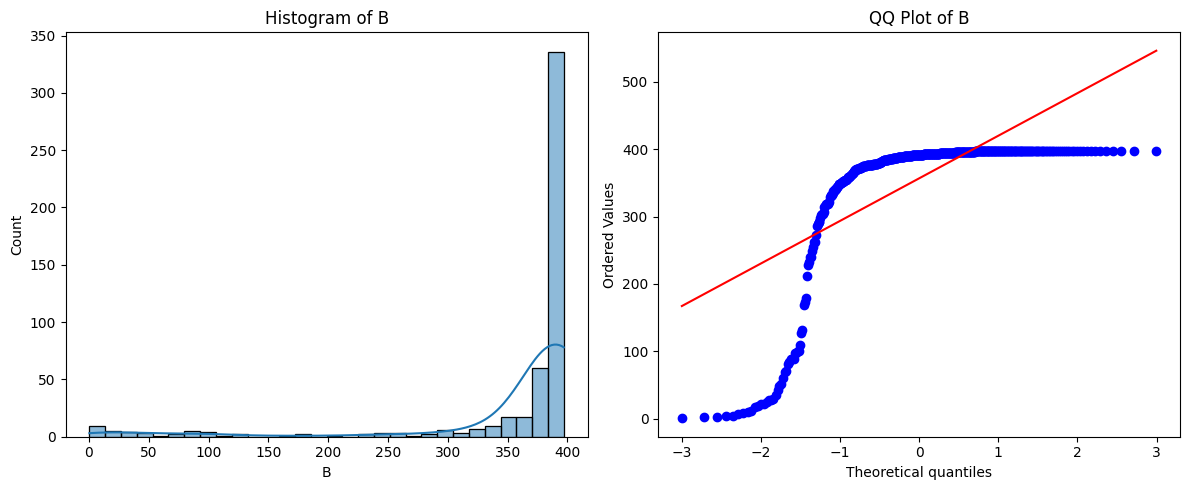

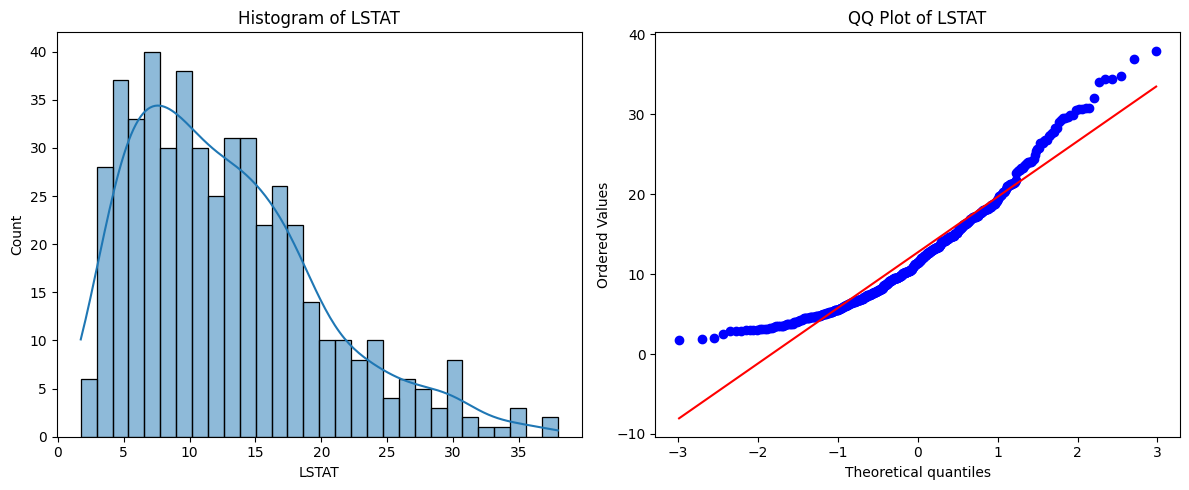

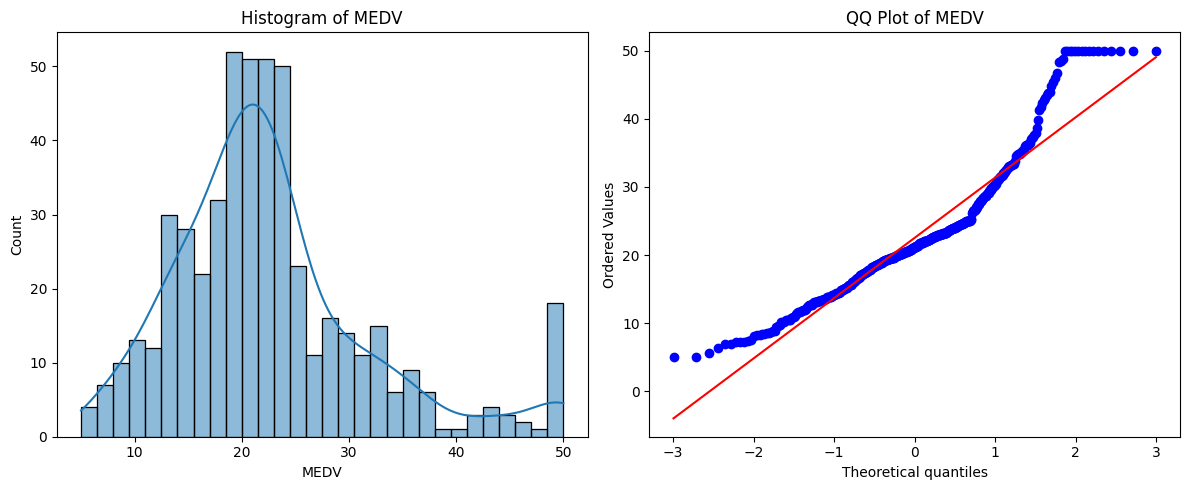

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_22856\844148319.py:20: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[column].fillna(median_value, inplace=True)
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_22856\844148319.py:20: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behave

In [8]:
# 정규성 검사 결과
normality_summary = shapiro_func(df, n_columns)

# 결측치 처리
def handle_missing_values(df, normality_info):
    for column in df.columns:
        if column == 'CHAS':
            # 최빈값 Charles River 인근 여부
            #mode_value=df[column].mode()[0]
            #df[column].fillna(mode_value, inplace=True)
            df.dropna(subset=[column], inplace=True)
            #상관관계가 없는 값이므로 결측치에 대해 dropna를 사용하였음.
        elif column in normality_info.index:
            if normality_info.loc[column, "Normal Distribution"]:
                mean_value = df[column].mean()
                df[column].fillna(mean_value, inplace=True)
                # 정규분포인 값들은 평균값
            else:
                median_value = df[column].median()
                df[column].fillna(median_value, inplace=True)
                # 정규분포가 아닌 값들은 중앙값
    return df

df_cleaned = handle_missing_values(df, normality_summary)

In [9]:
# 이상치 처리 함수
# IQR 
def handle_outliers(df, columns):
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df[col] = df[col].clip(lower=lower_bound, upper=upper_bound)
    return df
# clip 메서드를 이용하여 이상치들을 lower,upper bound값으로 바꿈
df_outliers_handled = handle_outliers(df_cleaned.copy(), n_columns)
# copy() 메서드를 사용해서 원본은 건드리지 않음.

print(df_outliers_handled.isnull().sum())

CRIM       0
ZN         0
INDUS      0
CHAS       0
NOX        0
RM         0
AGE        0
DIS        0
RAD        0
TAX        0
PTRATIO    0
B          0
LSTAT      0
MEDV       0
dtype: int64


In [10]:
# 데이터 분리
X = df_cleaned.drop(columns=['MEDV'])  # 'MEDV'는 타겟 변수
y = df_cleaned['MEDV']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# 모델별 성능
models = {
    "Random Forest": RandomForestRegressor(random_state=42),
    "XGBoost": XGBRegressor(random_state=42),
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(alpha=1.0),
    "Lasso Regression": Lasso(alpha=0.1)
}

results = []
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    results.append({"Model": name, "MSE": mse, "MAE": mae, "R²": r2})

results_df = pd.DataFrame(results)

print("\n모델 성능 비교:")
print(results_df)


모델 성능 비교:
               Model        MSE       MAE        R²
0      Random Forest  12.604975  2.167510  0.814713
1            XGBoost  10.509022  2.159179  0.845523
2  Linear Regression  18.782481  3.033474  0.723907
3   Ridge Regression  19.044555  3.028454  0.720055
4   Lasso Regression  18.976209  3.065392  0.721059


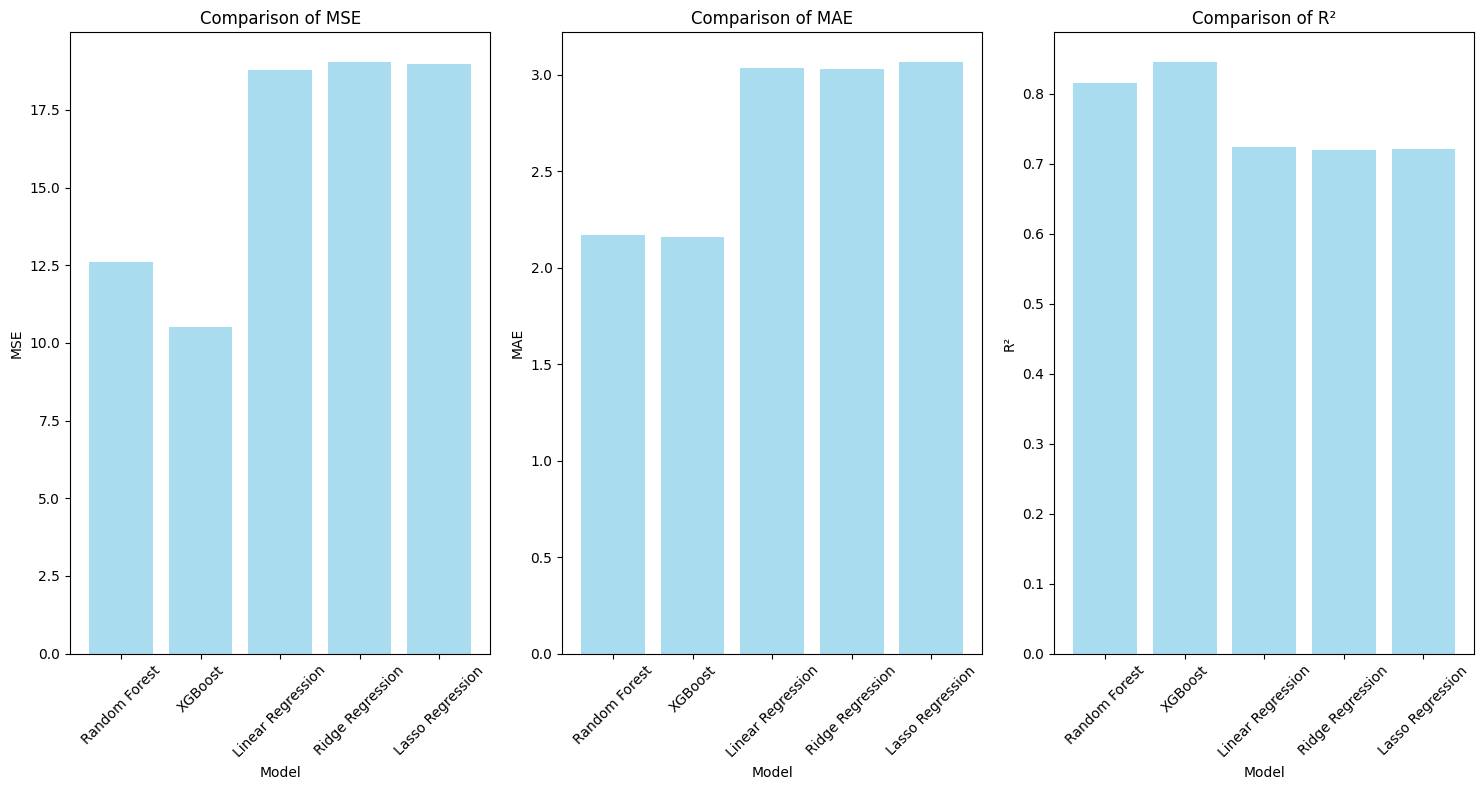

In [ ]:
import matplotlib.pyplot as plt

metrics = ["MSE","MAE","R²"]
plt.figure(figsize=(15,8))
for i,metric in enumerate(metrics):
    plt.subplot(1,3,i+1)
    plt.bar(results_df["Model"],results_df[metric],color="skyblue",alpha=0.7)
    plt.title(f"Comparison of {metric}")
    plt.xlabel("Model")
    plt.ylabel(metric)
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


# 하이퍼 파라미터

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV

# RandomizedSearchCV 실행


# randomforest 하이퍼 파라미터


rf_params_corrected = {
    "n_estimators": [100, 200, 500, 1000],
    "max_depth": [None, 10, 20, 30, 50],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "max_features": ['sqrt', 'log2'],  # 'auto' 제거
    "bootstrap": [True, False]
}



rf_random_corrected = RandomizedSearchCV(
    estimator=RandomForestRegressor(random_state=42),
    param_distributions=rf_params_corrected,
    n_iter=100,
    cv=5,
    scoring='r2',
    n_jobs=-1,
    random_state=42
)

# 모델 학습
rf_random_corrected.fit(X_train, y_train)

# 최적 하이퍼파라미터 및 결과
best_rf_corrected = rf_random_corrected.best_estimator_
y_pred_rf_corrected = best_rf_corrected.predict(X_test)

# 성능 평가
mse_rf_corrected = mean_squared_error(y_test, y_pred_rf_corrected)
r2_rf_corrected = r2_score(y_test, y_pred_rf_corrected)
mae_rf_corrected = mean_absolute_error(y_test, y_pred_rf_corrected)

# 결과 출력
#print("Best Hyperparameters for Random Forest (Corrected):", rf_random_corrected.best_params_)
#print(f"Random Forest Corrected (MSE): {mse_rf_corrected}")
#print(f"Random Forest Corrected (R²): {r2_rf_corrected}")
#print(f"Random Forest Corrected (MAE): {mae_rf_corrected}")


# xgboost 하이퍼 파라미터

xgb_params = {
    'n_estimators': [100, 200, 300, 400, 500],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 4, 5, 6, 7],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'reg_alpha': [0, 0.01, 0.1, 1],
    'reg_lambda': [1, 10, 100]
}

xgb_random = RandomizedSearchCV(
    estimator=XGBRegressor(random_state=42),
    param_distributions=xgb_params,
    n_iter=100,       # 랜덤 샘플링 횟수
    cv=5,             # 5-Fold 교차 검증
    scoring='r2',     # R² 스코어 사용
    n_jobs=-1,        # 병렬 처리
    random_state=42   # 결과 재현성 보장
)

xgb_random.fit(X_train, y_train)

# 최적 하이퍼파라미터 및 결과
best_xgb_corrected = xgb_random.best_estimator_
y_pred_xgb_corrected = best_xgb_corrected.predict(X_test)

# 성능 평가
mse_xgb_corrected = mean_squared_error(y_test, y_pred_xgb_corrected)
r2_xgb_corrected = r2_score(y_test, y_pred_xgb_corrected)
mae_xgb_corrected = mean_absolute_error(y_test, y_pred_xgb_corrected)

print("Best Hyperparameters for xgb (Corrected):", xgb_random.best_params_)
print(f"xgb Corrected (MSE): {mse_xgb_corrected}")
print(f"xgb Corrected (R2): {r2_xgb_corrected}")
print(f"xgb Corrected (MAE): {mae_xgb_corrected}")



'''
하이퍼 파라미터를 randomizedsearchcv를 통해 비교해보았으나 기존 기본값으로 비교된 값보다 안좋은 결과가 나왔음.

randomizedsearchcv는 모든 경우를 다 비교해 보는 것이 아니라 무작위로 선택되는 것이므로 운이 안좋아서 안좋은 결과가 나왔을 수도있고,

어쩌면 기본값이 최적화 되어있는 것일 수도 있다.
'''